## Data Analysis of InstaCart Market Basket dataset

This notebook serves as my capstone project for the **[Google Data Analytics](https://www.coursera.org/account/accomplishments/verify/V34P7Z7TDP8M)** course, and also for showing how I approach technical problems.

As a product manager, I've had to jump into Jupyter notebooks from time to time to look into the data, but never had to maintain the data itself. Now, as I'm trying to switch back to hands on technical roles, I'll probably need to maintain my own development environments for different projects or clients. This gave me a great excuse to learn Docker and create my own toolkit :)

My goal is to be able to spin up Anaconda and PostgreSQL in Docker in one go. I use Logseq as my learning journal and documented my steps. Finally finished and pushed it to Github here https://github.com/nicwn/conda-postgres

With this, I can clone this repo into a new folder, download whatever dataset I need to work with, spin up a new container and import the dataset into Postgres or just dig in in a Jupyter notebook.

As an example, I've downloaded this "[InstaCart Market Basket](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=8da413602ddb)" dataset to play with. “The Instacart Online Grocery Shopping Dataset 2017” (https://www.instacart.com/datasets/grocery-shopping-2017) consists of 3 million grocery orders from more than 200,000 InstaCart users for its 50,000 unique products from various aisles and departments. The data includes information such as the products ordered, the sequence in which they were added to the cart, the order day of the week and time of day when the order was placed. For information about the contents of the files, see this [data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*LNpbMMzWBsKqKyNvNH2APA.png)

First, I've imported the data into Postgres to do some exploratory data analysis. EDA is important as it helps us understand the data better so we can ask better questions which leads to better features engineering. As part of this process, I created this "[csv-to-sql-copy](https://github.com/nicwn/conda-postgres/blob/master/csv-to-sql-copy.ipynb)" script in my toolkit to help me quickly inspect and import CSV files into Postgres.

As someone with experience working across big corporations, startups and running my own small businesses, I understand all too well the disconnect between data analysts and business management. (Just knowing how to write queries and generating some generic charts is meaningless to business management who need that data to make business decisions.) I always begin my EDA with basic questions about the business: What kind of business is InstaCart? How does it make money? What are its expenses? What data is available? What are the short / long term goals of the business? What stage is the business in right now? What are the known hurdles? What would be interesting to the business? To the customers?… etc.

So, let's first look at the ERD to see how the data relate to each other:

![](./InstaCart_ERD.png)

The **orders** table is what ties everything together, it has 3.4m rows, with 206k unique users. It's connected to the **order_products_prior** table, which has 32m rows! That's all the past orders that has been placed. In comparison, the **order_products_train** table only has 1.3m rows in it, I guess they took the last few orders in their database, remove a few items from the end of each order, and put it here for the purpose of training new machine learning models? We're not gonna go into that here. Finally, there are 50K rows in **products**, which belong in 134 **aisles** and 21 **departments**.

Now, what would be some meaningful ways to look into the data? I can think of a few things that may give us meaningful insights:

1. **Customer Segmentation**: We can analyze customer behavior to identify different customer segments based on shopping patterns (when do they shop?), order frequency (how many days between each order?), and product preferences (what do they buy?). This information can help us tailor marketing campaigns and improve customer retention.

2. **Product Associations**: Discover frequent product sets and association rules between products to identify items that are often bought together. This is called **Frequent Itemset Mining** (FIM) and supermarkets have been using these data mining techniques to analyze the user buying pattern. This information can be used to create product bundles or develop targeted promotions, such as recommending additional items during the checkout process.

    (Product association heat map.)

3. **Popular Products**: Identify the most popular products in different aisles and departments. This will help us better manage our inventory and prioritize partnerships with suppliers.

    - Not just all time total. Try segmenting by time to discover sell rate for better inventory logistic.
    - Aisle and Department Popularity: Examine the sales volume and revenue generated by different aisles and departments, and identify the most and least popular categories.

4. **Day and Time of Orders**: Examine the days of the week and times of day when customers are most likely to place orders. This information can help us optimize our delivery schedules and staffing.

    - Order Frequency and Timing: Determine the most popular days and times for placing orders, and assess the impact of promotions on order frequency.
    - [Chart given by InstaCart on their blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=6f9dfbde5136) is very interesting - Sum of each product sold group by hour of day.

So, if you were a data analyst, what would you do first? I think a lot of us data geeks will be eager to jump into 2. **Product Associations** because we're itching to run some pattern mining algorithms! :) While I'm sure that'll yield some results, as an analyst, you should keep the high level goal of the company in mind before diving into time and resource intensive tasks, (like running FP-growth algorithm). Do a bit more high level EDA, check with the product team to see which areas are more relevant or higher in priority.

In InstaCart's case, I propose we look a little deeper in customer segments first. I would imagine there are csutomers who are higher value to the company, e.g. Users who make repeated orders more often, or in less time than mean. Users who make higher dollar amount orders (although that data isn't given here). etc… So, let's try and dig deeper into customers segments first.

### 1. Customer Segmentation

For patterns of when users do their shopping, we can look at the distribution of orders throughout a day like this:

```sql
SELECT order_hour_of_day, COUNT(*)
FROM public.orders
GROUP BY order_hour_of_day;
```

It'll be much easier to see this in a bar chart.

/opt/conda/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


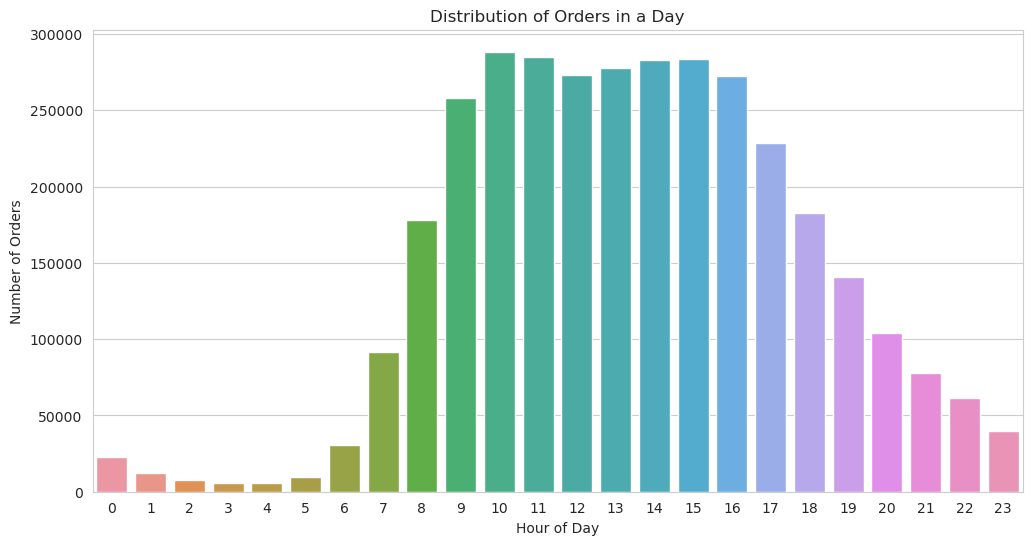

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up your PostgreSQL connection details
db_name = "InstaCart"
db_user = "nick"
db_password = "super5ecretPassword"
db_host = "my_pgdb"
db_port = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=db_name, user=db_user, password=db_password, host=db_host, port=db_port)

# Define the SQL query
sql_query = """
SELECT order_hour_of_day, COUNT(*)
FROM public.orders
GROUP BY order_hour_of_day;
"""

# Read the data from the PostgreSQL database into a pandas DataFrame
orders_hourly = pd.read_sql_query(sql_query, conn)

# Close the connection
conn.close()

# Create a bar chart of the distribution of orders in a day
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=orders_hourly['order_hour_of_day'], y=orders_hourly['count'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders in a Day')
plt.xticks(range(0, 24))
plt.show()


That doesn't tell us much about shopping patterns except most people shop during business hour. If our goal is to segment users by shopping patterns in order to create promotional campaigns, then we need to try and find segments that makes sense. Be curious, inquistive, put yourself in the shoes of the customers, and the business owners, follow the logical next steps in your investigation. These are some the most important qualities as a data analyst.

So here in this case, are there users who only or mostly order during weekdays business hours? Or some who only order during after hours? Only on weekends? That sounds plausible, right? If there are such segments, then we can look into their baskets to see what they buy. Let's have a look. First we'll need to figure out which day is which as the provided data didn't specify that.


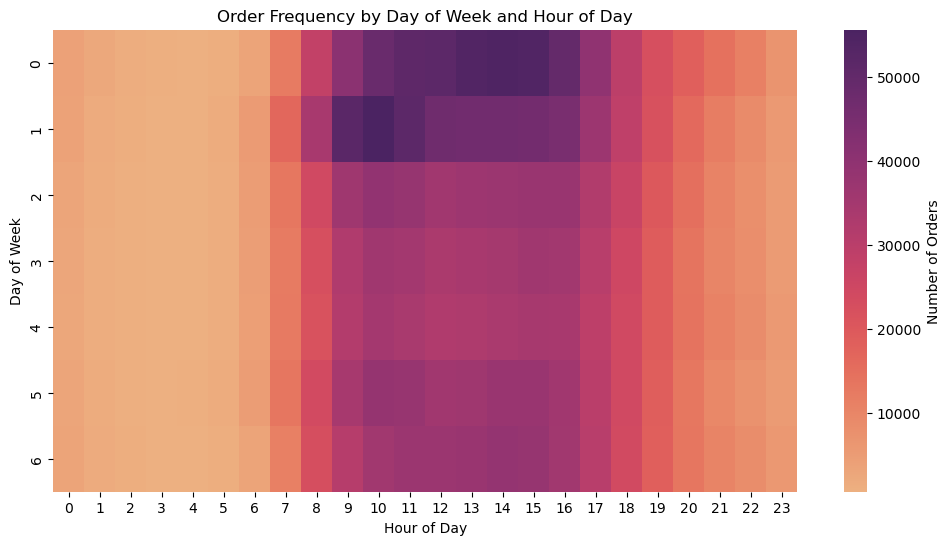

In [7]:
orders = pd.read_csv("orders.csv")

# Query the count of orders group by order_dow and order_hour_of_day
heatmap_data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].count().reset_index()

# Put result into pivot table
heatmap_table = heatmap_data.pivot(index='order_dow', columns='order_hour_of_day', values='order_id')

# Plot the heatmap using seaborn
plt.figure(figsize=(12, 6))
#sns.heatmap(heatmap_table, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Number of Orders'})
flare_cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap(heatmap_table, cmap=flare_cmap, cbar_kws={'label': 'Number of Orders'})
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Order Frequency by Day of Week and Hour of Day')
plt.show()


It's still a little hard to guess, I was expecting more obvious dip on Friday and Saturday nights. I guess there is a tiny bit of that, so probably day 0 is Sunday, 1 is Monday and so on. Now we can try to segment the users by "when do they make most (80%) of their purchases?"

In [25]:
orders = pd.read_csv("orders.csv")

# Count orders for each user during the defined time segments
weekday_daytime = orders[(orders['order_dow'].isin(range(1, 6))) & (orders['order_hour_of_day'].isin(range(9, 18)))].groupby('user_id')['order_id'].count()
weekday_nighttime = orders[(orders['order_dow'].isin([1, 2, 3, 4, 5])) & ((orders['order_hour_of_day'] >= 18) | (orders['order_hour_of_day'] <= 8))].groupby('user_id')['order_id'].count()
weekends = orders[(orders['order_dow'].isin([0, 6]))].groupby('user_id')['order_id'].count()

# Get the total number of orders for each user
total_orders = orders.groupby('user_id')['order_id'].count()

# Combine the above into a data frame
user_order_segments = pd.concat([weekday_daytime, weekday_nighttime, weekends, total_orders], axis=1, keys=['weekday_daytime_count', 'weekday_nighttime_count', 'weekend_count', 'total_count'])
user_order_segments.fillna(0, inplace=True)

# Append percentage of orders for each user in each time segment to data frame
user_order_segments['weekday_daytime_percentage'] = user_order_segments['weekday_daytime_count'] / user_order_segments['total_count']
user_order_segments['weekday_nighttime_percentage'] = user_order_segments['weekday_nighttime_count'] / user_order_segments['total_count']
user_order_segments['weekend_percentage'] = user_order_segments['weekend_count'] / user_order_segments['total_count']

# Assign users to time segment groups (80% threshold)
def assign_group(row):
    if row['weekday_daytime_percentage'] >= 0.8:
        return 'Weekday Daytime'
    elif row['weekday_nighttime_percentage'] >= 0.8:
        return 'Weekday Nighttime'
    elif row['weekend_percentage'] >= 0.8:
        return 'Weekends'
    else:
        return 'Mixed'

user_order_segments['user_group'] = user_order_segments.apply(assign_group, axis=1)

# Now each user has been assigned a segment
print(user_order_segments[['user_group']])

              user_group
user_id                 
1                  Mixed
2        Weekday Daytime
3                  Mixed
4        Weekday Daytime
5                  Mixed
...                  ...
205853          Weekends
205936          Weekends
206007          Weekends
206134          Weekends
206191          Weekends

[206209 rows x 1 columns]


Let's see how customers are now distributed now:

In [30]:
group_count = user_order_segments['user_group'].value_counts()
group_count

Mixed                166731
Weekday Daytime       28984
Weekends               9266
Weekday Nighttime      1228
Name: user_group, dtype: int64

That adds up to 206K users, good! But we can also see that most users are in the mixed group. Let's plot this in a chart to visualize the differences.

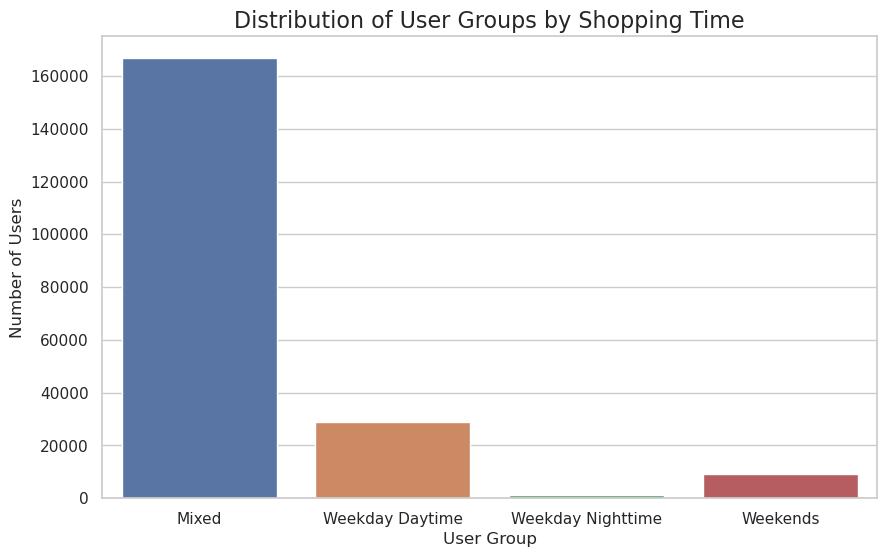

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=group_count.index, y=group_count.values, order=['Mixed', 'Weekday Daytime', 'Weekday Nighttime', 'Weekends'])

# Set plot title and labels
ax.set_title("Distribution of User Groups by Shopping Time", fontsize=16)
ax.set_xlabel("User Group", fontsize=12)
ax.set_ylabel("Number of Users", fontsize=12)

# Show the plot
plt.show()


We can see that while most users shop on InstaCart in a mixed of hours throughout the day, there's a non insignificant amount of users who shop exclusively during weekday business hours! While we haven't discovered any meaningful insight in 1. **Customer Segmentation**, we have found something for 4. **Day and Time of Orders**. This information about an extra 14% of users during business hours can help us optimize our delivery schedules and staffing.

Data Analytics is detective work. You look at the circumstantial evidence and form your hypothesis, then you write codes to dig into the data to see if your hypothesis is correct. Often times they're not, but we just need to stay curious and inquistive. Learn from the result and form our next hypothesis.

So, what would be a logical next step? We could look at the order frequency. Perhaps when we compare the customers who order more frequently, we'll find correlation with the order time groups. You can think through how to do this before writing the codes. e.g.

1. Find the distrbution of average number of days between orders per user.
2. Eye ball that distribution and set up the segments that make sense to business.
3. Separate users into segments, explore differences in purchases (do pattern mining algorithms).

Can you see what are some of the benefits to going through data analysis in this approach, as opposed to blindly diving into pattern mining algorithms with the whole dataset? By dividing users into logical segments, we get a smaller but more relevant subset of data to run pattern mining algorithms through! (Better suggestions for user group. Better customer journey to move low tier customers to high tier.?)

For the purpose of demonstration, I'll just use the "Weekday Daytime" group we've already created above to continue and perform pattern mining.


In [2]:
pip install mlxtend


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


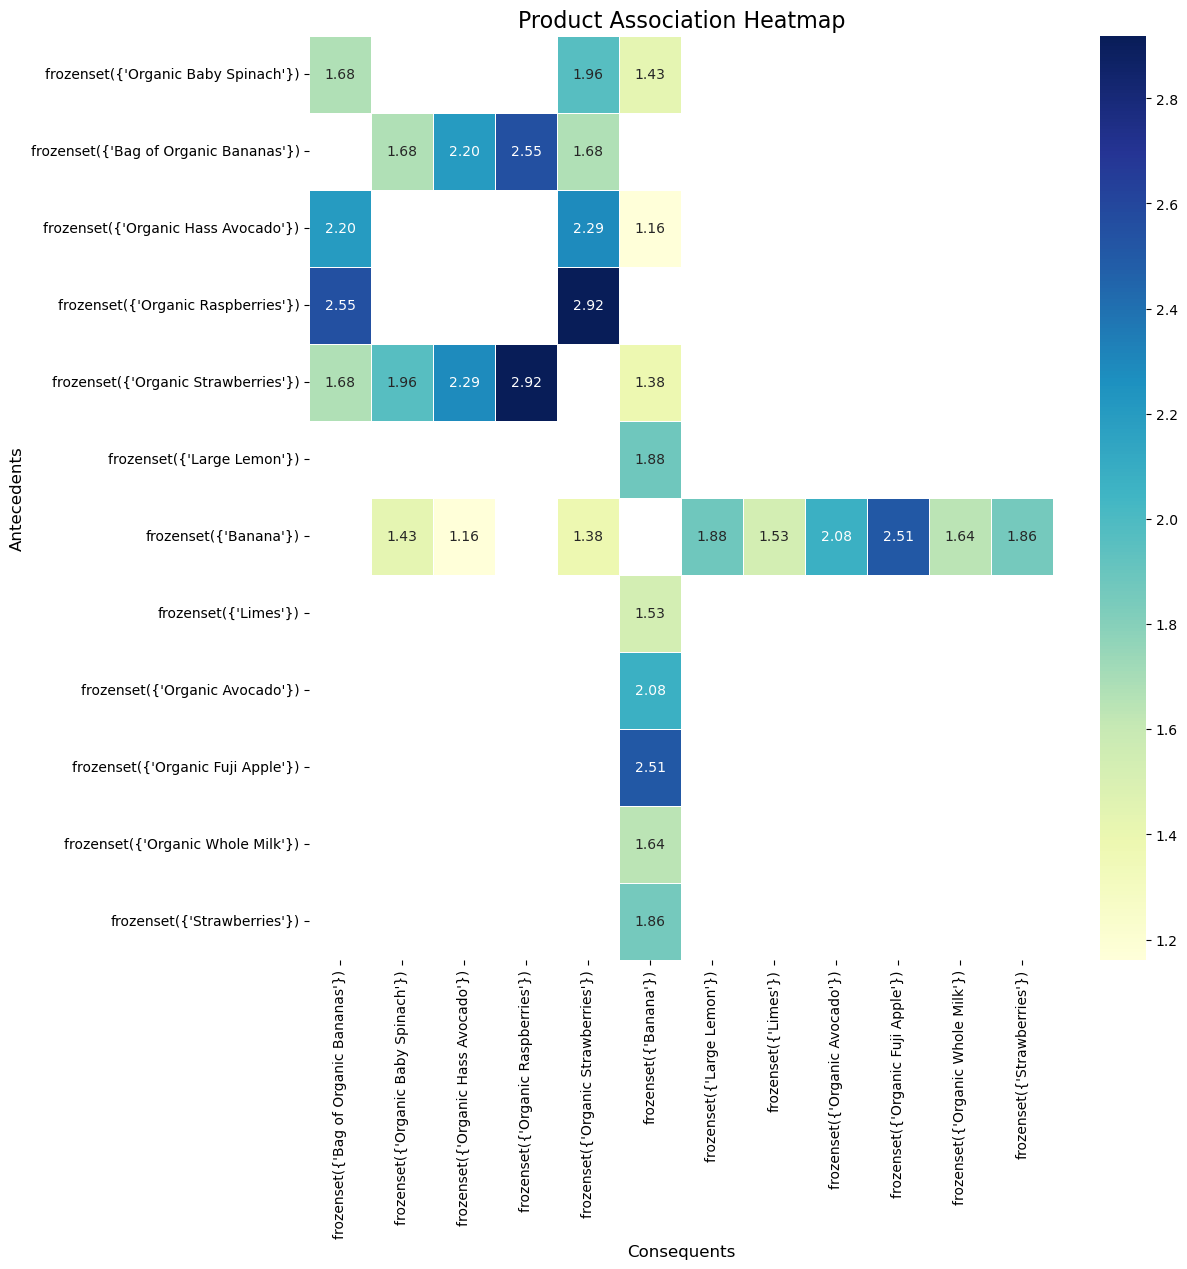

In [3]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

# Load order_products and products data
order_products = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv")

# Get a sample of orders to reduce the size of the dataset
sample_order_ids = order_products["order_id"].drop_duplicates().sample(10000, random_state=42)
sample_order_products = order_products[order_products["order_id"].isin(sample_order_ids)]

# Create a list of transactions (lists of product names)
transactions = []
for order_id, group in sample_order_products.groupby("order_id"):
    transactions.append(list(products.loc[products["product_id"].isin(group["product_id"]), "product_name"]))

# Encode the transactions
encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Calculate frequent itemsets
frequent_itemsets = apriori(transactions_df, min_support=0.01, use_colnames=True)

# Calculate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Create a pivot table for the heatmap
heatmap_data = rules.pivot_table(index="antecedents", columns="consequents", values="lift", aggfunc="max")

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Product Association Heatmap", fontsize=16)
plt.xlabel("Consequents", fontsize=12)
plt.ylabel("Antecedents", fontsize=12)
plt.show()

